In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
from google.colab import drive
drive.mount('/content/drive')

FILE_PATH = os.path.join('drive', 'My Drive', 'Data-Driven Project/Data/bandit.csv')
bandit_data = pd.read_csv(FILE_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
bandit_data['Intercept'] = 1
bandit_data

,CustomerID,Gender,Tenure_Months,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,GST,Offline_Spend,Online_Spend,...,Location_New Jersey,Location_New York,Location_Washington DC,Product_Category_Bag&Accessory,Product_Category_Life,Product_Category_Nest,Product_Category_Office,Coupon_Status_Not Used,Coupon_Status_Used,Intercept
0,17850.0,1,-1.050567,16679.0,1.0,1.574413,-0.294433,-0.816962,1.784164,0.657132,...,False,False,False,False,False,True,False,False,True,1
1,17850.0,1,-1.050567,16680.0,1.0,1.574413,-0.294433,-0.816962,1.784164,0.657132,...,False,False,False,False,False,True,False,False,True,1
2,17850.0,1,-1.050567,16696.0,2.0,1.091773,-0.294433,-0.816962,1.784164,0.657132,...,False,False,False,False,False,True,False,True,False,1
3,17850.0,1,-1.050567,16699.0,1.0,0.447992,-0.294433,-0.816962,1.784164,0.657132,...,False,False,False,False,False,True,False,False,False,1
4,17850.0,1,-1.050567,16700.0,1.0,1.574413,-0.294433,-0.816962,1.784164,0.657132,...,False,False,False,False,False,True,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51495,13155.0,0,-1.347411,22504.0,1.0,3.076465,-1.141610,-1.908551,-0.356976,-0.744618,...,False,False,False,False,True,False,False,False,False,1
51496,18077.0,1,0.582073,24250.0,1.0,-0.433366,-1.141610,-1.908551,-0.892261,-1.027503,...,False,False,False,False,True,False,False,False,True,1
51497,16085.0,1,-0.827935,39991.0,1.0,-0.654875,-0.359601,-1.908551,0.178309,0.416860,...,False,False,False,False,False,False,True,False,False,1
51498,16085.0,1,-0.827935,39991.0,1.0,-0.673594,-0.359601,-1.908551,0.178309,0.416860,...,False,False,False,False,False,False,True,False,True,1


## LinUCB

- Context: Gender, Location, Tenure_Months, Month.
These are the customer information.

- Action: Product_Category, which refers to the product being recommended.

- Reward: Total_Spending, representing the amount spent by the customer per transaction.

In [ ]:
context = ['Intercept', 'Gender', 'Tenure_Months', 'Month', 'Location_Chicago', 'Location_New Jersey',
       'Location_New York', 'Location_Washington DC']

action = ['Product_Category_Bag&Accessory', 'Product_Category_Life',
       'Product_Category_Nest', 'Product_Category_Office'] # In total, there are 5 actions. Here are 4 due to dummy encoding

reward1 = 'Total_Spending'

In [ ]:
# Initialize Aa = Id and ba = 0d for each arm a with d dimentional context
def compute_ucb(x, A, b, alpha):
  # UCB for each arms
  UCB = []
  for i in range(len(b)):
    Ainv = np.linalg.inv(A[i])
    Rhat = x @ Ainv @ b[i]
    Uhat = alpha * np.sqrt(x.T @ Ainv @ x)
    UCB.append(Rhat + Uhat)
  return np.array(UCB)

In [ ]:
def linucb(alpha, bandit_data, trials, reward_function):
    D = len(context) - 1 # dimention of context
    K = 5 # arms

    # initialize the A and b
    A = [np.eye(D+1) for i in range(K)]
    b = [np.zeros(D+1) for i in range(K)]
    regret = np.zeros(trials)

    for n in range(trials):
      sample = np.random.randint(0,len(bandit_data))
      current = bandit_data.iloc[sample]
      x = current[context]
      UCB = compute_ucb(x, A, b, alpha)
      idx = np.argmax(UCB)

      # pull the arm for bandit
      if idx != 4:
        a = action[idx]
        r = current[a] * current[reward_function]
      else:
        r = (1 - current[action].sum()) * current[reward_function]

      # update A and b
      x = np.array(x, dtype='float')
      A[idx] += np.outer(x,x)
      b[idx] += r * x
      regret[n] = current[reward_function] - r

    return regret

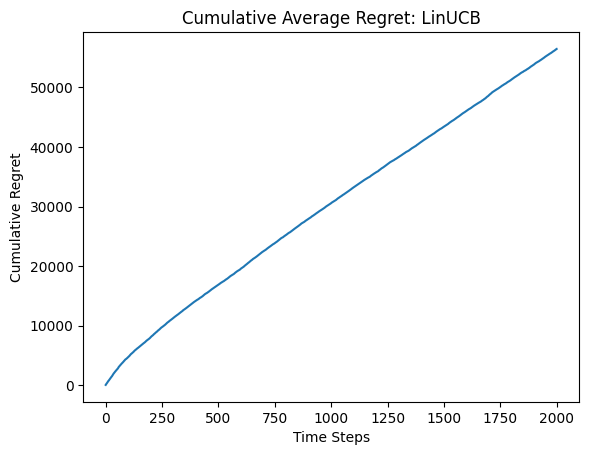

In [ ]:
trials, sims, alpha = 2000, 50, 1

avg_regret = np.zeros(trials)
for m in range(sims):
    regret = linucb(alpha, bandit_data, trials, reward1)
    avg_regret += regret
avg_regret /= sims

plt.title('Cumulative Average Regret: LinUCB')
plt.plot(np.cumsum(avg_regret))
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Regret')
plt.show()

## Epsilon-Greedy

In [ ]:
def egreedy(bandit_data, epsilon, trials, sims, reward_function):
    K = 5 # arms

    Qall = np.array([np.zeros(K) for i in range(trials)])
    regret = np.zeros(trials)   # Instantaneous regret at each trial

    for m in range(sims):
        Q = np.zeros(K)         # Q-values
        N = np.zeros(K)         # Counts

        for n in range(trials):
            sample = bandit_data.iloc[np.random.randint(0,len(bandit_data))]

            if np.random.random() < epsilon:
                idx = np.random.randint(0, K)
            else:
                idx = np.argmax(Q)

            # pull the arm for bandit
            if idx != 4:
                a = action[idx]
                r = sample[a] * sample[reward_function]
            else:
                r = (1 - sample[action].sum()) * sample[reward_function]

            N[idx] += 1
            Q[idx] += 1/N[idx] * (r - Q[idx])

            Qall[n] += Q
            regret[n] += sample[reward_function] - r

    Qall = Qall.T
    Qall[0] /= sims
    Qall[1] /= sims
    Qall[2] /= sims
    Qall[3] /= sims
    Qall[4] /= sims
    regret /= sims

    return Qall[0], Qall[1], Qall[2], Qall[3], Qall[4], regret

epsilon =  0.05


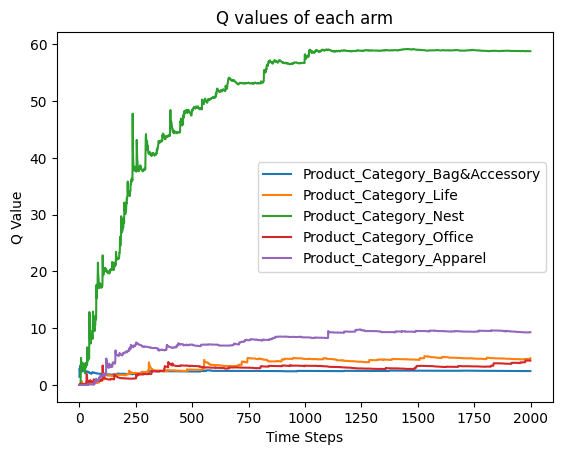

epsilon =  0.1


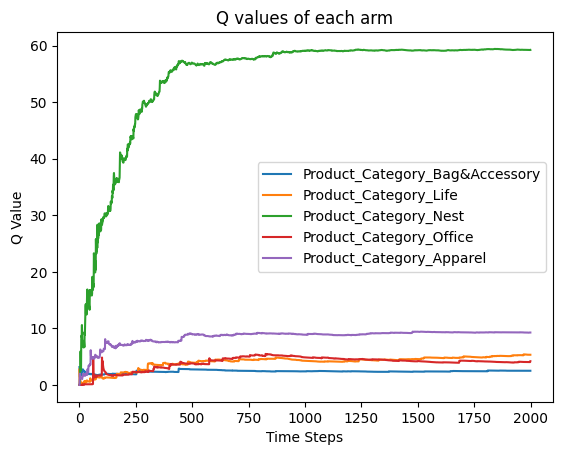

epsilon =  0.15


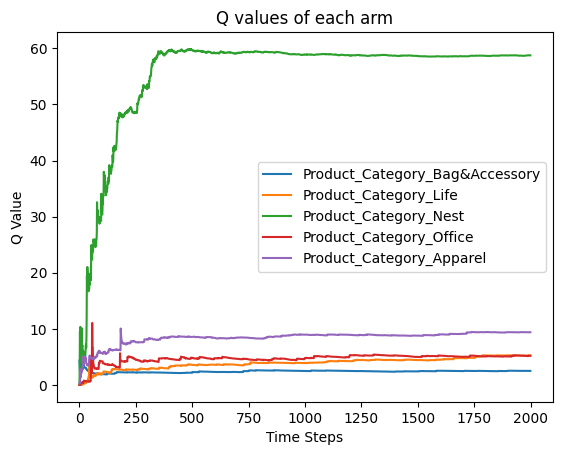

epsilon =  0.2


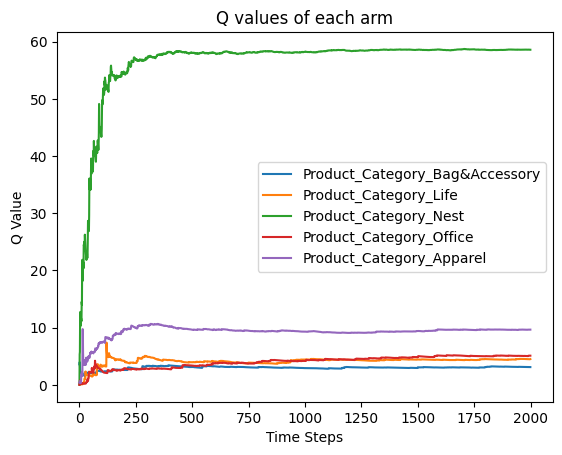

epsilon =  0.25


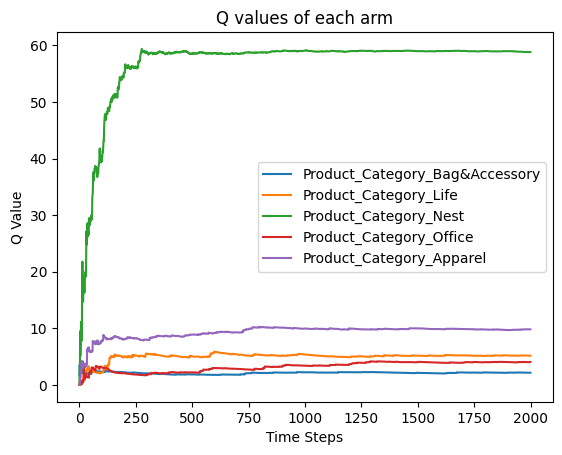

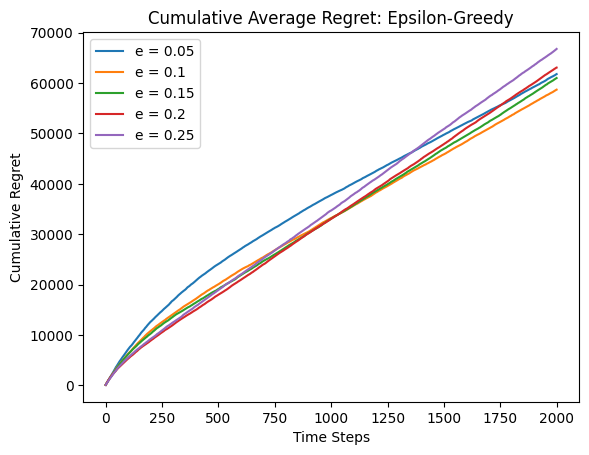

In [ ]:
epsilons = [.05,.1,.15,.2,.25]
trials, sims = 2000, 50
final_regret = []
for e in epsilons:
  Q1, Q2, Q3, Q4, Q5, regret = egreedy(bandit_data, e, trials, sims, reward1)
  print('epsilon = ', e)

  plt.title('Q values of each arm')
  plt.plot(Q1, label= action[0])
  plt.plot(Q2, label= action[1])
  plt.plot(Q3, label= action[2])
  plt.plot(Q4, label= action[3])
  plt.plot(Q5, label= 'Product_Category_Apparel')
  plt.xlabel('Time Steps')
  plt.ylabel('Q Value')
  plt.legend()
  plt.show()
  final_regret.append(regret)

plt.title('Cumulative Average Regret: Epsilon-Greedy')
for i in range(5):
  regret = final_regret[i]
  plt.plot(np.cumsum(regret), label = 'e = ' + str(epsilons[i]))
  plt.legend()
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Regret')
plt.show()